# <center>Bad Banking Behavior<br>Analyzing Bank Mortgage during the 2008 Housing Bubble</center>  

<center>Michael Siebel</center>
<center>December 2020</center>

<br>

## <center>Model Runs Script</center>
<br>

# Objectives  
<br>

> In the models below, I use two primary ensembling techniques. The first, algorithm-based ensembling, rebalances the data to augment foreclosure predictions. The second uses vote ensembling to increase generalization of each model’s results.
<br><br>
Models were run on datasets containing an individual bank and a dataset of all 9 banks (for a total of 10 datasets). 


## Table of Contents
- [Goals](#Goals)<br>
- [Load Packages](#Load-Packages)<br>
- [Data Wrangling](#Data-Wrangling)<br>
- [Modeling Steps](#Modeling-Steps)<br>
- [Bottom Layer](#Bottom-Layer)<br>
- [Middle Layer](#Middle-Layer)
- [Top Layer](#Top-Layer)<br>
- [Save Objects](#Save-Objects)

***

# Load Functions

In [1]:
# Load functions
%run Functions.ipynb
pd.set_option("display.max_columns", 200)
pd.set_option('display.max_rows', 200)

# Load data
file_to_open = open('..\Data\Pickle\df.pkl', 'rb') 
df  = pickle.load(file_to_open) 
file_to_open.close()

# Drop mergeID column
df = df.drop(labels='Loan ID', axis=1)

# Convert Inf values to NA
df = df.replace([np.inf, -np.inf], np.nan)

Using TensorFlow backend.


***

# Data Wrangling

In [2]:
# Verify Bank Counts
df['Bank'].value_counts()

Bank of America      650087
CitiMortgage         260698
Wells Fargo Bank     214039
JPMorgan Chase       202997
GMAC Mortgage        178160
SunTrust Mortgage    141398
PNC Bank             100351
AmTrust Bank          79360
Flagstar Bank         66637
Name: Bank, dtype: int64

In [3]:
# Variables to drop
dropvars = ['File Year', 'Year', 'Month', 'Region', 'FIPS', # 'Reported Period', 
            'Zip Code', 'Mortgage Insurance Type', 'Property State',
            'First Payment', 'Original Loan-to-Value (LTV)']
df = df.drop(labels=dropvars, axis=1)
df = df.filter(regex=r'^(?!Asset).*$')
df = df.filter(regex=r'^(?!Liab).*$')
df = df.filter(regex=r'^(?!Eqtot).*$')
df = df.filter(regex=r'^(?!Dep).*$')

# Convert Original Date to Numeric
df['Reported Period'] = df['Reported Period'].astype(float).astype(int).astype(str)
df['Reported Period'] = df['Reported Period'].apply(lambda x: x.zfill(6))
df['Reported Period'] = df['Reported Period'].map(lambda x: x[:2] + '/' + x[2:])
df = change_date(df, 'Reported Period')
df = change_date(df, 'Original Date')

# Missingness to drop
df = df.dropna()

# All data
y_all = df['Foreclosed']
X_all = df.drop(labels=['Foreclosed', 'Zero Balance Code'], axis=1) 

# Split Train (70%)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.7, 
                                                    stratify = y_all, random_state=2019)
# Split Val (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, 
                                                stratify = y_test, random_state=2019)

# One hot encoding on remaining data
Bnk_train = X_train['Bank'].reset_index().iloc[:,1]
X_train = onehotencoding(X_train)
Bnk_val = X_val['Bank'].reset_index().iloc[:,1]
X_val = onehotencoding(X_val)
Bnk_test = X_test['Bank'].reset_index().iloc[:,1]
X_test = onehotencoding(X_test)

In [4]:
# Update Macroeconomic variables (will not use test set)
X_train, X_val, X_test = pca_fred(X_train, X_val, X_test)

# Check columns
X_train.columns

Index(['Reported Period', 'Original Interest Rate', 'Original Mortgage Amount',
       'Original Loan Term', 'Original Date',
       'Original Combined Loan-to-Value (CLTV)', 'Single Borrower',
       'Original Debt to Income Ratio', 'Loan Purpose', 'Number of Units',
       'Mortgage Insurance %', 'Credit Score', 'Loan Change (1 Year)',
       'Loan Change (5 Years)', 'Median Household Income',
       'Number of Employees', 'Lnlsnet (5 Yr)', 'Lnlsnet (1 Yr)',
       'Origination Channel_B', 'Origination Channel_C',
       'Origination Channel_R', 'Bank_AmTrust Bank', 'Bank_Bank of America',
       'Bank_CitiMortgage', 'Bank_Flagstar Bank', 'Bank_GMAC Mortgage',
       'Bank_JPMorgan Chase', 'Bank_PNC Bank', 'Bank_SunTrust Mortgage',
       'Bank_Wells Fargo Bank', 'First Time Home Buyer_N',
       'First Time Home Buyer_Y', 'Property Type_CO', 'Property Type_CP',
       'Property Type_MH', 'Property Type_PU', 'Property Type_SF',
       'Occupancy Type_I', 'Occupancy Type_P', 'Occupanc

In [5]:
# List of banks
banks = ['Bank of America','Wells Fargo Bank','CitiMortgage',
         'JPMorgan Chase','GMAC Mortgage','SunTrust Mortgage',
         'AmTrust Bank','PNC Bank','Flagstar Bank']

# Run Function
Banks_X, Banks_y = Bank_Subsets(banks, df_X = X_train, df_y = y_train)
Banks_X_val, Banks_y_val = Bank_Subsets(banks, df_X = X_val, df_y = y_val)
Banks_X_test, Banks_y_test = Bank_Subsets(banks, df_X = X_test, df_y = y_test)
X_train = X_train.filter(regex=r'^(?!Bank).*$')
X_val = X_val.filter(regex=r'^(?!Bank).*$')
X_test = X_test.filter(regex=r'^(?!Bank).*$')

print('Shape:', X_train.shape)

Shape: (483564, 42)


***

# Modeling Steps

### 1) Run bagging models (Ind banks/all banks)
### 2) Determine best thresholds on test data
### 3) Middle layer vote classifier on all banks
### 4) Vote classifier on ind banks and majority of all banks

# Bottom Layer

Bank of America Model
 -  Pipeline(steps=[('sclr', StandardScaler()),
                ('rfc1',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_features='sqrt', n_jobs=-1,
                                                random_state=2020,
                                                sampling_strategy={0: 1500,
                                                                   1: 300}))])
Best Params
{'rfc1__min_samples_split': 6, 'rfc1__n_estimators': 50}
Best Threshold


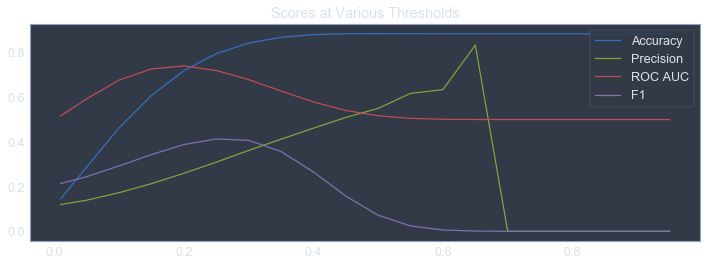

              precision    recall  f1-score   support

           0       0.94      0.82      0.88    195942
           1       0.31      0.62      0.41     25777

    accuracy                           0.79    221719
   macro avg       0.63      0.72      0.64    221719
weighted avg       0.87      0.79      0.82    221719



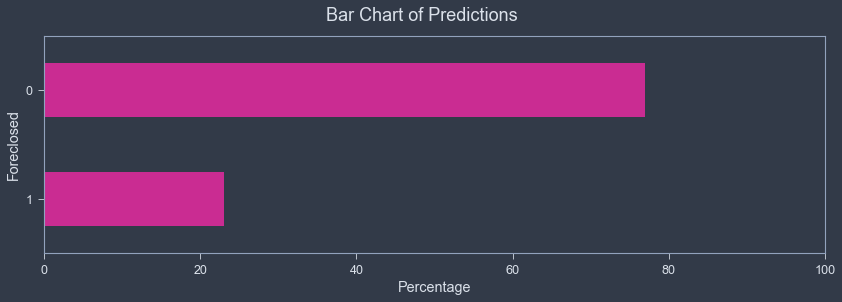

Frequency of Foreclosures
0    170510
1     51908
Name: 1, dtype: int64

Percentage of Foreclosures
0    77
1    23
Name: 1, dtype: int32

None
F1 Score 0.41

Confusion Matrix
[[160700  35781]
 [  9810  16127]]

Bank of America Model
 -  Pipeline(steps=[('sclr', StandardScaler()), ('pca', PCA()),
                ('rfc2',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_features=None, n_jobs=-1,
                                                random_state=2022,
                                                replacement=True))])
Best Params
{'pca__n_components': 15, 'rfc2__min_samples_split': 13, 'rfc2__n_estimators': 750}
Best Threshold


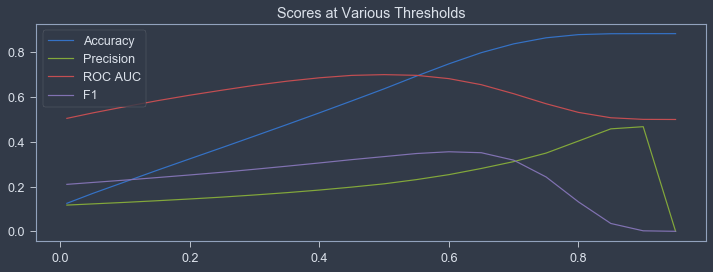

              precision    recall  f1-score   support

           0       0.94      0.77      0.84    195942
           1       0.25      0.60      0.36     25777

    accuracy                           0.75    221719
   macro avg       0.59      0.68      0.60    221719
weighted avg       0.86      0.75      0.79    221719



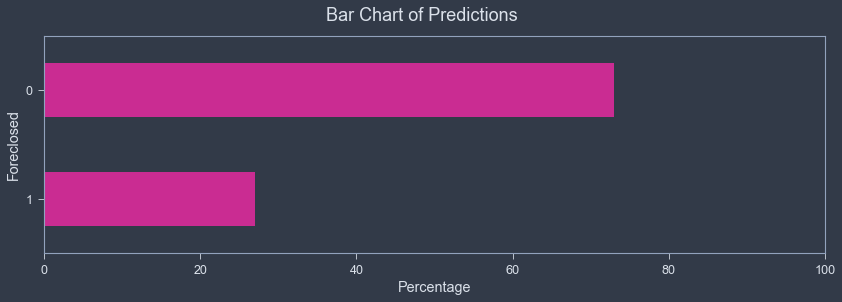

Frequency of Foreclosures
0    161489
1     60929
Name: 1, dtype: int64

Percentage of Foreclosures
0    73
1    27
Name: 1, dtype: int32

None
F1 Score 0.35

Confusion Matrix
[[150957  45524]
 [ 10532  15405]]

Bank of America Model
 -  Pipeline(steps=[('sclr', StandardScaler()),
                ('rus',
                 RUSBoostClassifier(n_estimators=500, random_state=2023,
                                    sampling_strategy={0: 900, 1: 300}))])
Best Params
{'rus__learning_rate': 0.1}
Best Threshold


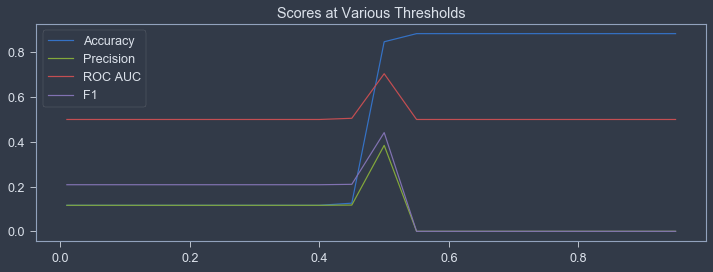

              precision    recall  f1-score   support

           0       0.93      0.89      0.91    195942
           1       0.38      0.52      0.44     25777

    accuracy                           0.85    221719
   macro avg       0.66      0.70      0.68    221719
weighted avg       0.87      0.85      0.86    221719



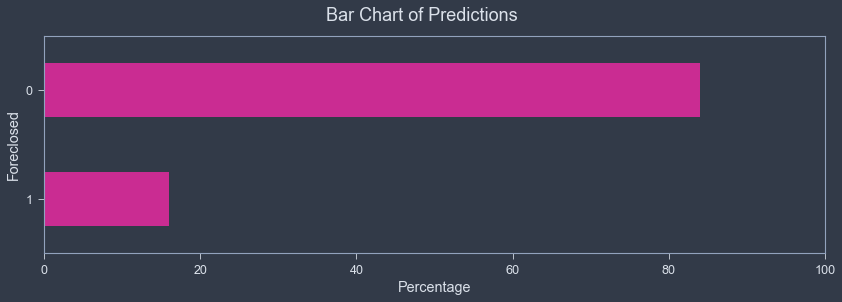

Frequency of Foreclosures
0    187573
1     34845
Name: 1, dtype: int64

Percentage of Foreclosures
0    84
1    16
Name: 1, dtype: int32

None
F1 Score 0.44

Confusion Matrix
[[175127  21354]
 [ 12446  13491]]

Wells Fargo Bank Model
 -  Pipeline(steps=[('sclr', StandardScaler()),
                ('rfc1',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_features='sqrt', n_jobs=-1,
                                                random_state=2020,
                                                sampling_strategy={0: 1500,
                                                                   1: 300}))])
Best Params
{'rfc1__min_samples_split': 4, 'rfc1__n_estimators': 50}
Best Threshold


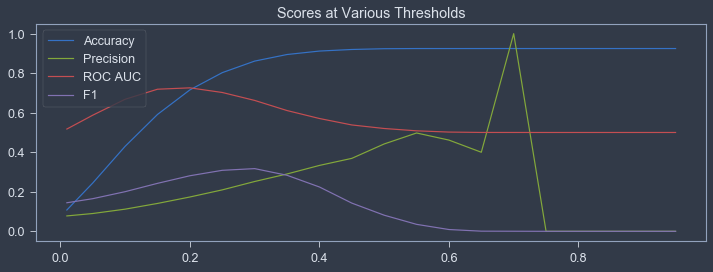

              precision    recall  f1-score   support

           0       0.95      0.90      0.92     64459
           1       0.25      0.43      0.32      5254

    accuracy                           0.86     69713
   macro avg       0.60      0.66      0.62     69713
weighted avg       0.90      0.86      0.88     69713



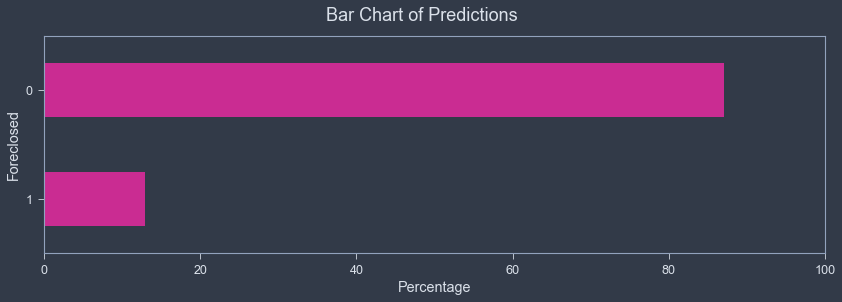

Frequency of Foreclosures
0    61042
1     8926
Name: 1, dtype: int64

Percentage of Foreclosures
0    87
1    13
Name: 1, dtype: int32

None
F1 Score 0.31

Confusion Matrix
[[57945  6699]
 [ 3097  2227]]

Wells Fargo Bank Model
 -  Pipeline(steps=[('sclr', StandardScaler()), ('pca', PCA()),
                ('rfc2',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_features=None, n_jobs=-1,
                                                random_state=2022,
                                                replacement=True))])
Best Params
{'pca__n_components': 15, 'rfc2__min_samples_split': 16, 'rfc2__n_estimators': 500}
Best Threshold


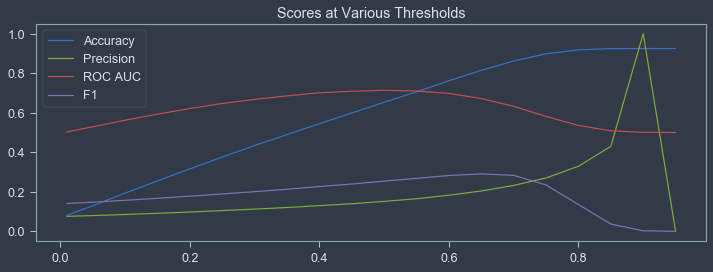

              precision    recall  f1-score   support

           0       0.95      0.84      0.89     64459
           1       0.20      0.50      0.29      5254

    accuracy                           0.81     69713
   macro avg       0.58      0.67      0.59     69713
weighted avg       0.90      0.81      0.85     69713



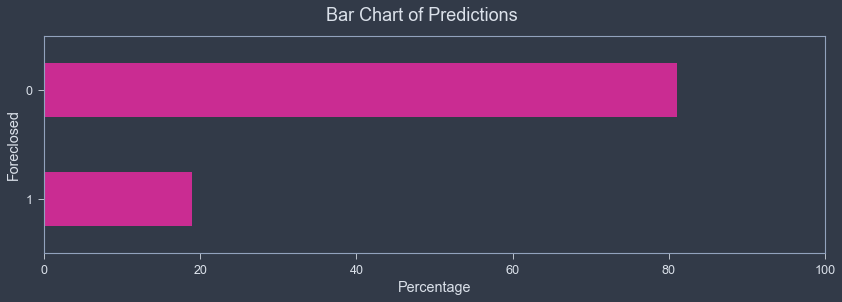

Frequency of Foreclosures
0    56678
1    13290
Name: 1, dtype: int64

Percentage of Foreclosures
0    81
1    19
Name: 1, dtype: int32

None
F1 Score 0.29

Confusion Matrix
[[54040 10604]
 [ 2638  2686]]

Wells Fargo Bank Model
 -  Pipeline(steps=[('sclr', StandardScaler()),
                ('rus',
                 RUSBoostClassifier(n_estimators=500, random_state=2023,
                                    sampling_strategy={0: 900, 1: 300}))])
Best Params
{'rus__learning_rate': 0.2}
Best Threshold


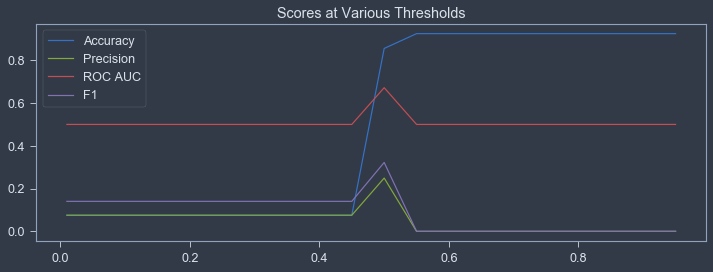

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     64459
           1       0.25      0.46      0.32      5254

    accuracy                           0.86     69713
   macro avg       0.60      0.67      0.62     69713
weighted avg       0.90      0.86      0.87     69713



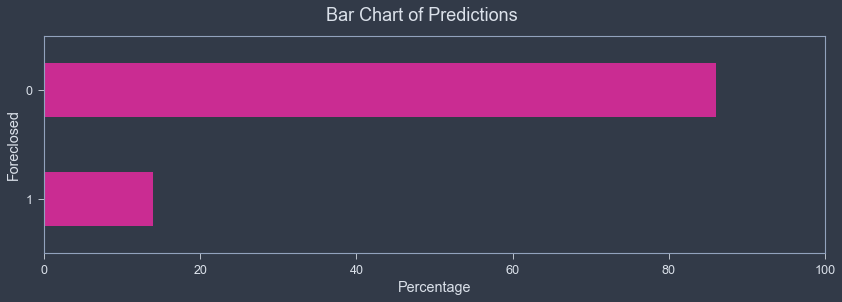

Frequency of Foreclosures
0    60383
1     9585
Name: 1, dtype: int64

Percentage of Foreclosures
0    86
1    14
Name: 1, dtype: int32

None
F1 Score 0.32

Confusion Matrix
[[57471  7173]
 [ 2912  2412]]

CitiMortgage Model
 -  Pipeline(steps=[('sclr', StandardScaler()),
                ('rfc1',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_features='sqrt', n_jobs=-1,
                                                random_state=2020,
                                                sampling_strategy={0: 1500,
                                                                   1: 300}))])
Best Params
{'rfc1__min_samples_split': 2, 'rfc1__n_estimators': 50}
Best Threshold


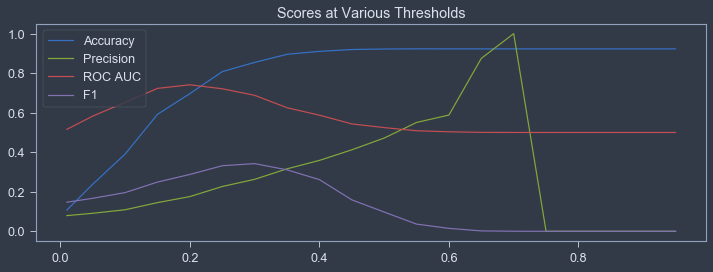

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     79185
           1       0.26      0.49      0.34      6619

    accuracy                           0.85     85804
   macro avg       0.61      0.69      0.63     85804
weighted avg       0.90      0.85      0.87     85804



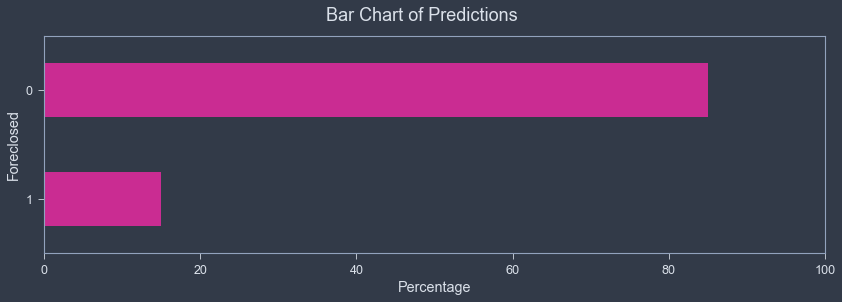

Frequency of Foreclosures
0    73475
1    12490
Name: 1, dtype: int64

Percentage of Foreclosures
0    85
1    15
Name: 1, dtype: int32

None
F1 Score 0.34

Confusion Matrix
[[70133  9232]
 [ 3342  3258]]

CitiMortgage Model
 -  Pipeline(steps=[('sclr', StandardScaler()), ('pca', PCA()),
                ('rfc2',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_features=None, n_jobs=-1,
                                                random_state=2022,
                                                replacement=True))])
Best Params
{'pca__n_components': 15, 'rfc2__min_samples_split': 10, 'rfc2__n_estimators': 500}
Best Threshold


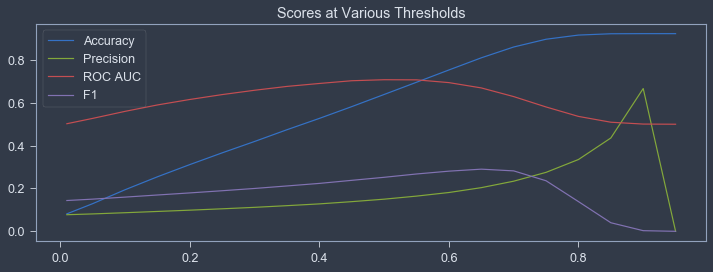

              precision    recall  f1-score   support

           0       0.95      0.84      0.89     79185
           1       0.20      0.50      0.29      6619

    accuracy                           0.81     85804
   macro avg       0.58      0.67      0.59     85804
weighted avg       0.89      0.81      0.84     85804



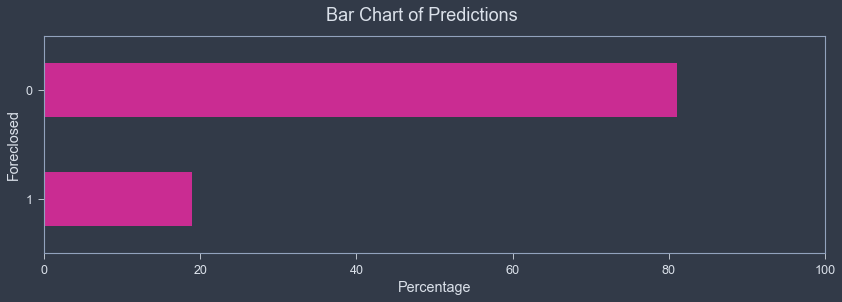

Frequency of Foreclosures
0    69598
1    16367
Name: 1, dtype: int64

Percentage of Foreclosures
0    81
1    19
Name: 1, dtype: int32

None
F1 Score 0.29

Confusion Matrix
[[66298 13067]
 [ 3300  3300]]

CitiMortgage Model
 -  Pipeline(steps=[('sclr', StandardScaler()),
                ('rus',
                 RUSBoostClassifier(n_estimators=500, random_state=2023,
                                    sampling_strategy={0: 900, 1: 300}))])
Best Params
{'rus__learning_rate': 0.1}
Best Threshold


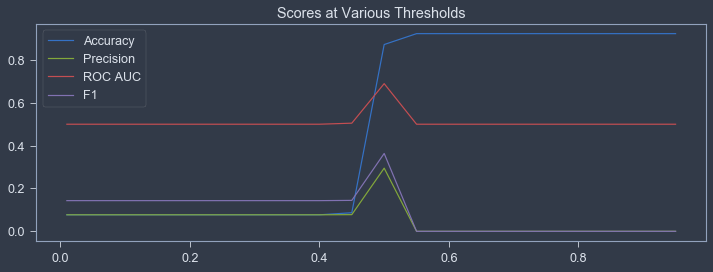

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     79185
           1       0.29      0.47      0.36      6619

    accuracy                           0.87     85804
   macro avg       0.62      0.69      0.65     85804
weighted avg       0.90      0.87      0.89     85804



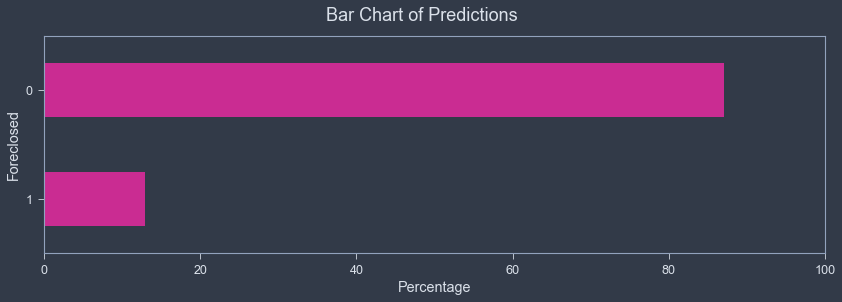

Frequency of Foreclosures
0    75079
1    10886
Name: 1, dtype: int64

Percentage of Foreclosures
0    87
1    13
Name: 1, dtype: int32

None
F1 Score 0.36

Confusion Matrix
[[71629  7736]
 [ 3450  3150]]

JPMorgan Chase Model
 -  Pipeline(steps=[('sclr', StandardScaler()),
                ('rfc1',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_features='sqrt', n_jobs=-1,
                                                random_state=2020,
                                                sampling_strategy={0: 1500,
                                                                   1: 300}))])
Best Params
{'rfc1__min_samples_split': 4, 'rfc1__n_estimators': 50}
Best Threshold


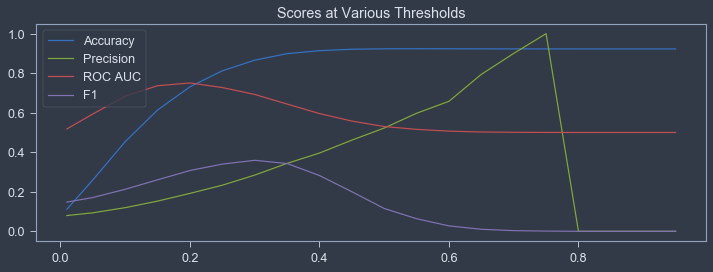

              precision    recall  f1-score   support

           0       0.95      0.90      0.92     62161
           1       0.28      0.49      0.36      5200

    accuracy                           0.87     67361
   macro avg       0.62      0.69      0.64     67361
weighted avg       0.90      0.87      0.88     67361



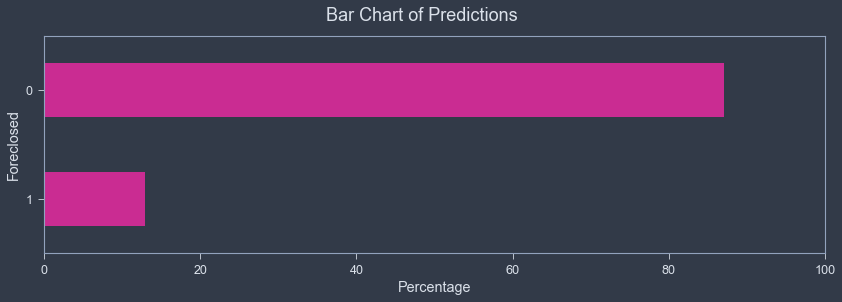

Frequency of Foreclosures
0    57821
1     8858
Name: 1, dtype: int64

Percentage of Foreclosures
0    87
1    13
Name: 1, dtype: int32

None
F1 Score 0.36

Confusion Matrix
[[55317  6356]
 [ 2504  2502]]

JPMorgan Chase Model
 -  Pipeline(steps=[('sclr', StandardScaler()), ('pca', PCA()),
                ('rfc2',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_features=None, n_jobs=-1,
                                                random_state=2022,
                                                replacement=True))])
Best Params
{'pca__n_components': 15, 'rfc2__min_samples_split': 16, 'rfc2__n_estimators': 500}
Best Threshold


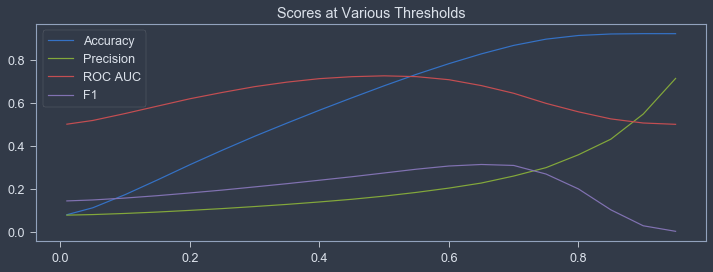

              precision    recall  f1-score   support

           0       0.95      0.86      0.90     62161
           1       0.23      0.51      0.31      5200

    accuracy                           0.83     67361
   macro avg       0.59      0.68      0.61     67361
weighted avg       0.90      0.83      0.86     67361



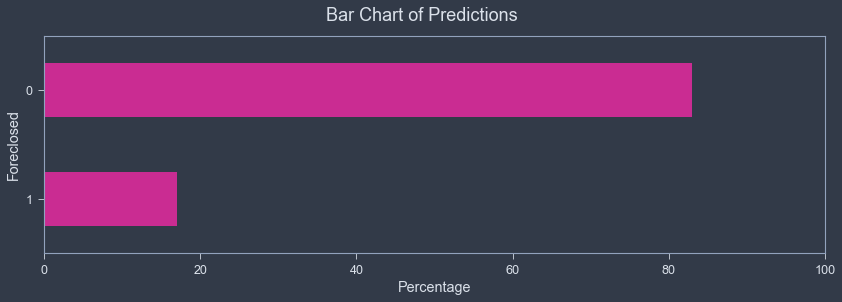

Frequency of Foreclosures
0    55107
1    11572
Name: 1, dtype: int64

Percentage of Foreclosures
0    83
1    17
Name: 1, dtype: int32

None
F1 Score 0.31

Confusion Matrix
[[52633  9040]
 [ 2474  2532]]

JPMorgan Chase Model
 -  Pipeline(steps=[('sclr', StandardScaler()),
                ('rus',
                 RUSBoostClassifier(n_estimators=500, random_state=2023,
                                    sampling_strategy={0: 900, 1: 300}))])
Best Params
{'rus__learning_rate': 0.1}
Best Threshold


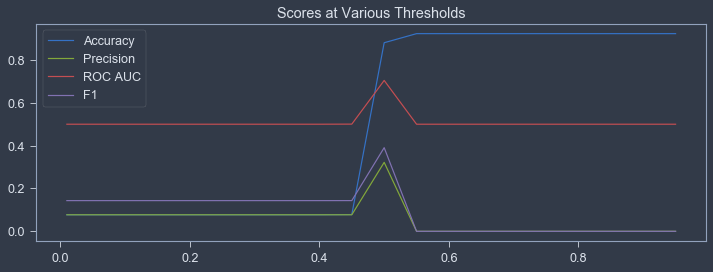

              precision    recall  f1-score   support

           0       0.96      0.91      0.93     62161
           1       0.32      0.50      0.39      5200

    accuracy                           0.88     67361
   macro avg       0.64      0.70      0.66     67361
weighted avg       0.91      0.88      0.89     67361



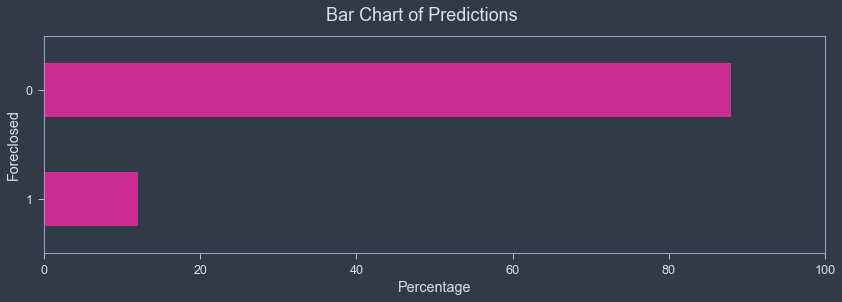

Frequency of Foreclosures
0    58741
1     7938
Name: 1, dtype: int64

Percentage of Foreclosures
0    88
1    12
Name: 1, dtype: int32

None
F1 Score 0.39

Confusion Matrix
[[56247  5426]
 [ 2494  2512]]

GMAC Mortgage Model
 -  Pipeline(steps=[('sclr', StandardScaler()),
                ('rfc1',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_features='sqrt', n_jobs=-1,
                                                random_state=2020,
                                                sampling_strategy={0: 1500,
                                                                   1: 300}))])
Best Params
{'rfc1__min_samples_split': 4, 'rfc1__n_estimators': 50}
Best Threshold


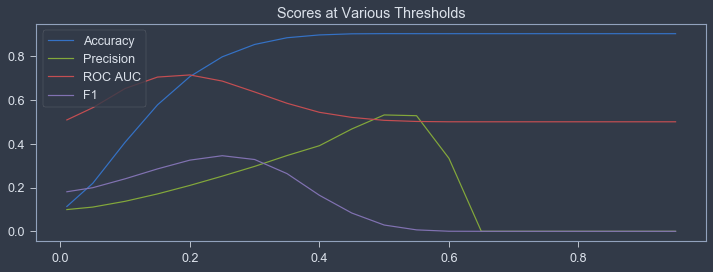

              precision    recall  f1-score   support

           0       0.94      0.82      0.88     53173
           1       0.25      0.55      0.35      5760

    accuracy                           0.80     58933
   macro avg       0.60      0.69      0.61     58933
weighted avg       0.88      0.80      0.83     58933



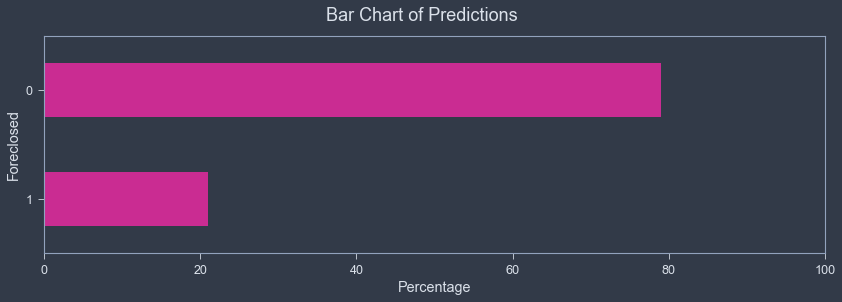

Frequency of Foreclosures
0    46366
1    12540
Name: 1, dtype: int64

Percentage of Foreclosures
0    79
1    21
Name: 1, dtype: int32

None
F1 Score 0.35

Confusion Matrix
[[43849  9385]
 [ 2517  3155]]

GMAC Mortgage Model
 -  Pipeline(steps=[('sclr', StandardScaler()), ('pca', PCA()),
                ('rfc2',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_features=None, n_jobs=-1,
                                                random_state=2022,
                                                replacement=True))])
Best Params
{'pca__n_components': 15, 'rfc2__min_samples_split': 13, 'rfc2__n_estimators': 500}
Best Threshold


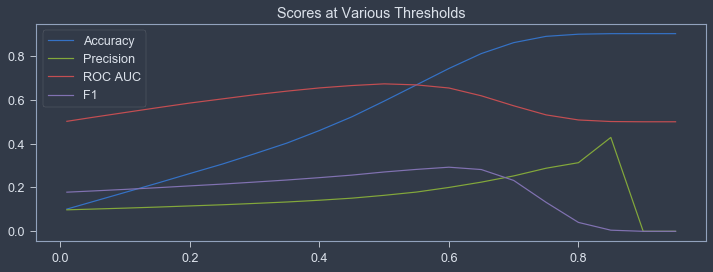

              precision    recall  f1-score   support

           0       0.94      0.76      0.84     53173
           1       0.20      0.54      0.29      5760

    accuracy                           0.74     58933
   macro avg       0.57      0.65      0.57     58933
weighted avg       0.87      0.74      0.79     58933



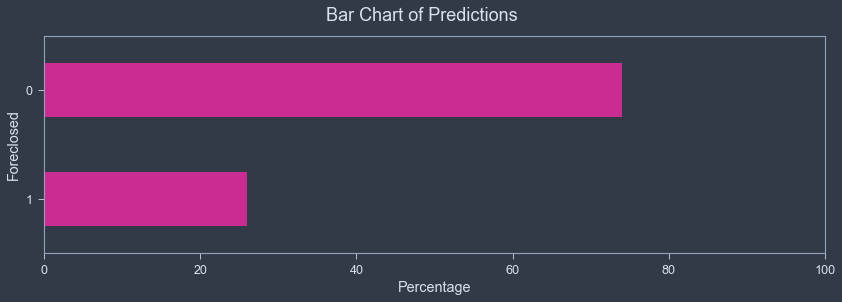

Frequency of Foreclosures
0    43349
1    15557
Name: 1, dtype: int64

Percentage of Foreclosures
0    74
1    26
Name: 1, dtype: int32

None
F1 Score 0.29

Confusion Matrix
[[40716 12518]
 [ 2633  3039]]

GMAC Mortgage Model
 -  Pipeline(steps=[('sclr', StandardScaler()),
                ('rus',
                 RUSBoostClassifier(n_estimators=500, random_state=2023,
                                    sampling_strategy={0: 900, 1: 300}))])
Best Params
{'rus__learning_rate': 0.1}
Best Threshold


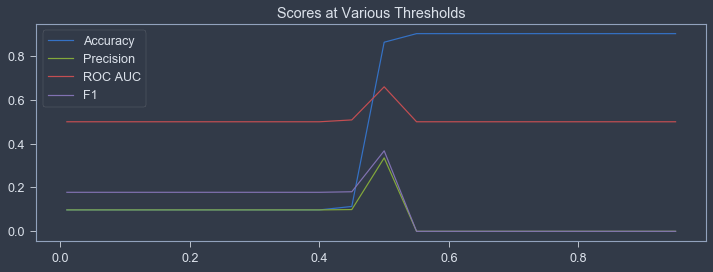

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     53173
           1       0.34      0.41      0.37      5760

    accuracy                           0.86     58933
   macro avg       0.63      0.66      0.65     58933
weighted avg       0.88      0.86      0.87     58933



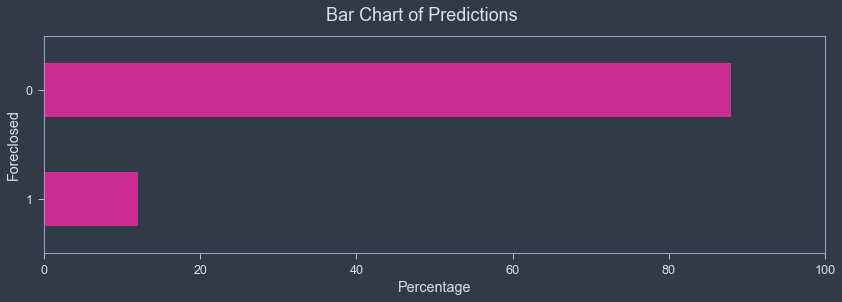

Frequency of Foreclosures
0    51860
1     7046
Name: 1, dtype: int64

Percentage of Foreclosures
0    88
1    12
Name: 1, dtype: int32

None
F1 Score 0.37

Confusion Matrix
[[48531  4703]
 [ 3329  2343]]

SunTrust Mortgage Model
 -  Pipeline(steps=[('sclr', StandardScaler()),
                ('rfc1',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_features='sqrt', n_jobs=-1,
                                                random_state=2020,
                                                sampling_strategy={0: 1500,
                                                                   1: 300}))])
Best Params
{'rfc1__min_samples_split': 2, 'rfc1__n_estimators': 75}
Best Threshold


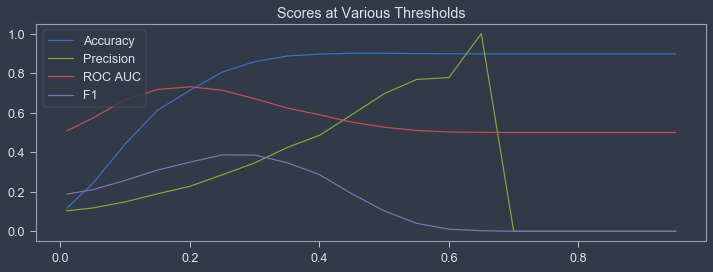

              precision    recall  f1-score   support

           0       0.95      0.83      0.88     22287
           1       0.29      0.60      0.39      2543

    accuracy                           0.81     24830
   macro avg       0.62      0.71      0.64     24830
weighted avg       0.88      0.81      0.83     24830



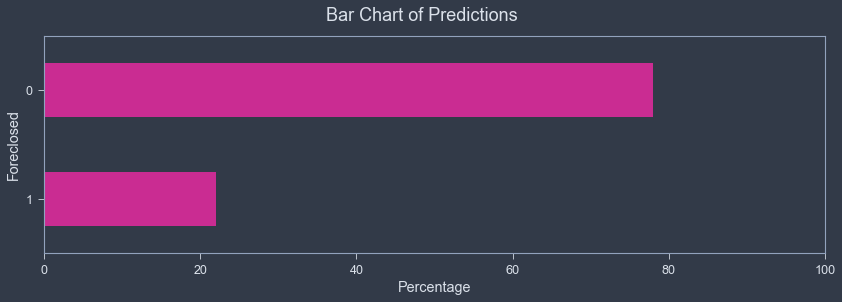

Frequency of Foreclosures
0    19253
1     5448
Name: 1, dtype: int64

Percentage of Foreclosures
0    78
1    22
Name: 1, dtype: int32

None
F1 Score 0.38

Confusion Matrix
[[18234  3907]
 [ 1019  1541]]

SunTrust Mortgage Model
 -  Pipeline(steps=[('sclr', StandardScaler()), ('pca', PCA()),
                ('rfc2',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_features=None, n_jobs=-1,
                                                random_state=2022,
                                                replacement=True))])
Best Params
{'pca__n_components': 15, 'rfc2__min_samples_split': 16, 'rfc2__n_estimators': 750}
Best Threshold


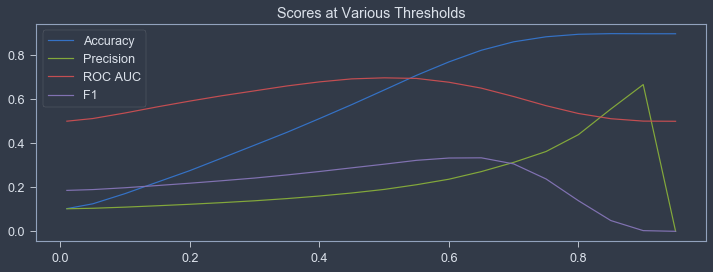

              precision    recall  f1-score   support

           0       0.93      0.87      0.90     22287
           1       0.27      0.43      0.33      2543

    accuracy                           0.82     24830
   macro avg       0.60      0.65      0.62     24830
weighted avg       0.86      0.82      0.84     24830



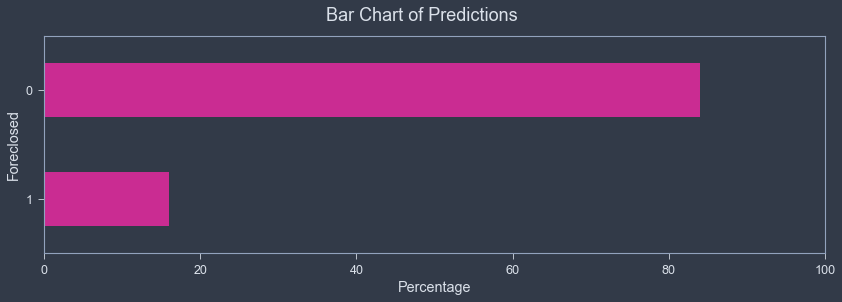

Frequency of Foreclosures
0    20691
1     4010
Name: 1, dtype: int64

Percentage of Foreclosures
0    84
1    16
Name: 1, dtype: int32

None
F1 Score 0.34

Confusion Matrix
[[19253  2888]
 [ 1438  1122]]

SunTrust Mortgage Model
 -  Pipeline(steps=[('sclr', StandardScaler()),
                ('rus',
                 RUSBoostClassifier(n_estimators=500, random_state=2023,
                                    sampling_strategy={0: 900, 1: 300}))])
Best Params
{'rus__learning_rate': 0.15}
Best Threshold


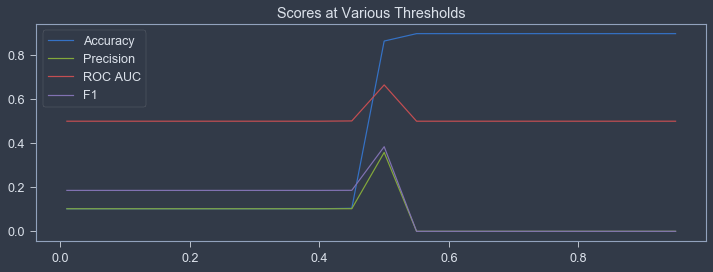

              precision    recall  f1-score   support

           0       0.93      0.92      0.92     22287
           1       0.36      0.41      0.38      2543

    accuracy                           0.86     24830
   macro avg       0.65      0.66      0.65     24830
weighted avg       0.87      0.86      0.87     24830



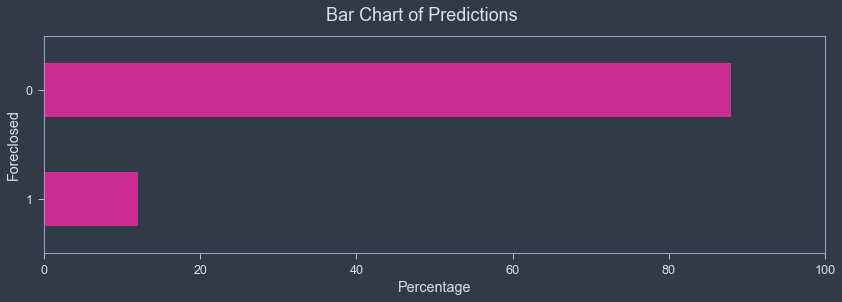

Frequency of Foreclosures
0    21724
1     2977
Name: 1, dtype: int64

Percentage of Foreclosures
0    88
1    12
Name: 1, dtype: int32

None
F1 Score 0.39

Confusion Matrix
[[20249  1892]
 [ 1475  1085]]

AmTrust Bank Model
 -  Pipeline(steps=[('sclr', StandardScaler()),
                ('rfc1',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_features='sqrt', n_jobs=-1,
                                                random_state=2020,
                                                sampling_strategy={0: 1500,
                                                                   1: 300}))])
Best Params
{'rfc1__min_samples_split': 6, 'rfc1__n_estimators': 50}
Best Threshold


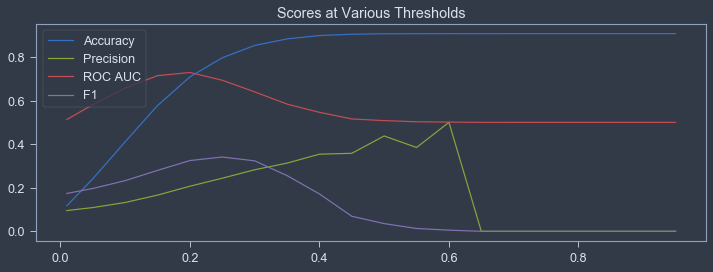

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      7408
           1       0.24      0.57      0.34       759

    accuracy                           0.80      8167
   macro avg       0.60      0.69      0.61      8167
weighted avg       0.88      0.80      0.83      8167



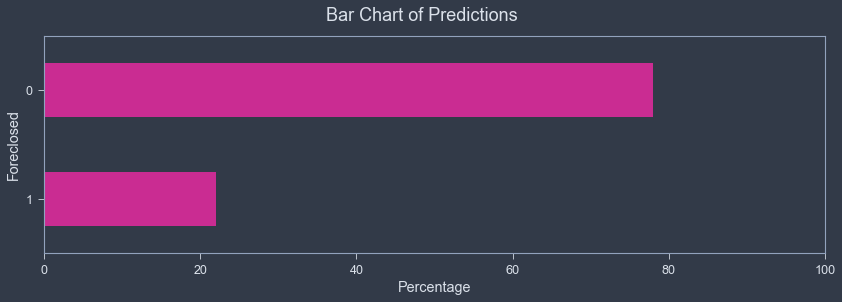

Frequency of Foreclosures
0    6407
1    1764
Name: 1, dtype: int64

Percentage of Foreclosures
0    78
1    22
Name: 1, dtype: int32

None
F1 Score 0.33

Confusion Matrix
[[6040 1350]
 [ 367  414]]

AmTrust Bank Model
 -  Pipeline(steps=[('sclr', StandardScaler()), ('pca', PCA()),
                ('rfc2',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_features=None, n_jobs=-1,
                                                random_state=2022,
                                                replacement=True))])
Best Params
{'pca__n_components': 15, 'rfc2__min_samples_split': 10, 'rfc2__n_estimators': 750}
Best Threshold


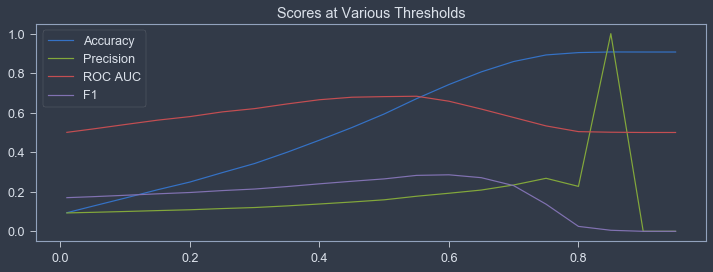

              precision    recall  f1-score   support

           0       0.94      0.76      0.84      7408
           1       0.19      0.55      0.29       759

    accuracy                           0.74      8167
   macro avg       0.57      0.66      0.56      8167
weighted avg       0.87      0.74      0.79      8167



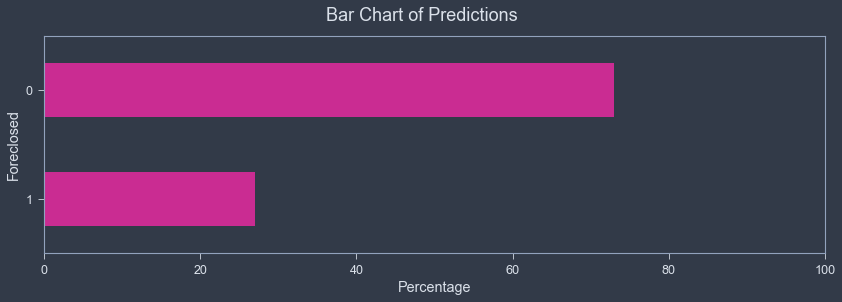

Frequency of Foreclosures
0    6001
1    2170
Name: 1, dtype: int64

Percentage of Foreclosures
0    73
1    27
Name: 1, dtype: int32

None
F1 Score 0.27

Confusion Matrix
[[5623 1767]
 [ 378  403]]

AmTrust Bank Model
 -  Pipeline(steps=[('sclr', StandardScaler()),
                ('rus',
                 RUSBoostClassifier(n_estimators=500, random_state=2023,
                                    sampling_strategy={0: 900, 1: 300}))])
Best Params
{'rus__learning_rate': 0.2}
Best Threshold


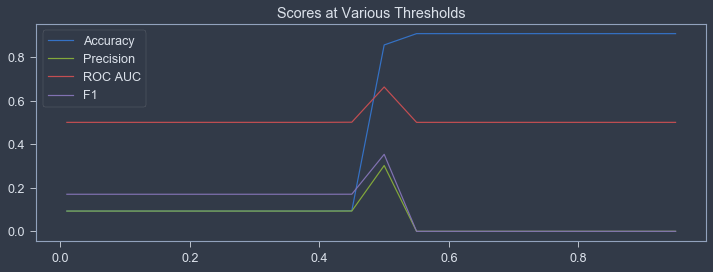

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      7408
           1       0.30      0.43      0.35       759

    accuracy                           0.86      8167
   macro avg       0.62      0.66      0.64      8167
weighted avg       0.88      0.86      0.87      8167



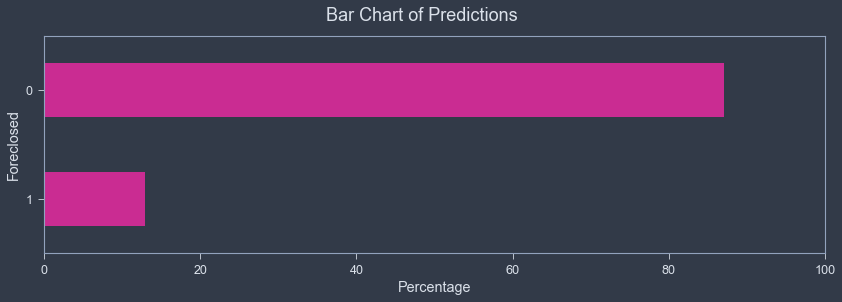

Frequency of Foreclosures
0    7076
1    1095
Name: 1, dtype: int64

Percentage of Foreclosures
0    87
1    13
Name: 1, dtype: int32

None
F1 Score 0.34

Confusion Matrix
[[6613  777]
 [ 463  318]]

PNC Bank Model
 -  Pipeline(steps=[('sclr', StandardScaler()),
                ('rfc1',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_features='sqrt', n_jobs=-1,
                                                random_state=2020,
                                                sampling_strategy={0: 1500,
                                                                   1: 300}))])
Best Params
{'rfc1__min_samples_split': 2, 'rfc1__n_estimators': 50}
Best Threshold


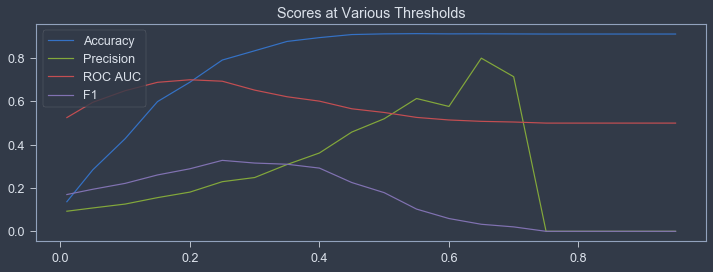

              precision    recall  f1-score   support

           0       0.95      0.81      0.88      4962
           1       0.23      0.57      0.33       482

    accuracy                           0.79      5444
   macro avg       0.59      0.69      0.60      5444
weighted avg       0.89      0.79      0.83      5444



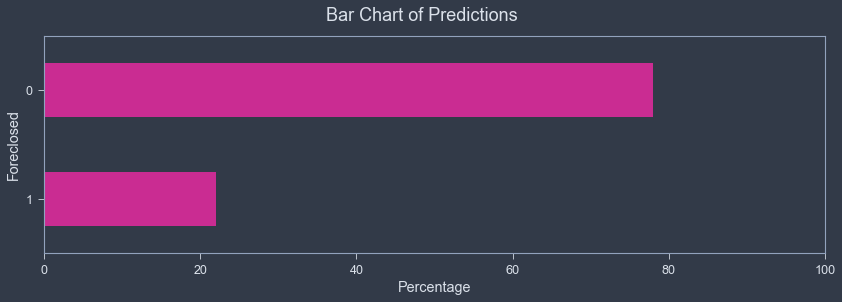

Frequency of Foreclosures
0    4292
1    1199
Name: 1, dtype: int64

Percentage of Foreclosures
0    78
1    22
Name: 1, dtype: int32

None
F1 Score 0.33

Confusion Matrix
[[4071  917]
 [ 221  282]]

PNC Bank Model
 -  Pipeline(steps=[('sclr', StandardScaler()), ('pca', PCA()),
                ('rfc2',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_features=None, n_jobs=-1,
                                                random_state=2022,
                                                replacement=True))])
Best Params
{'pca__n_components': 15, 'rfc2__min_samples_split': 10, 'rfc2__n_estimators': 750}
Best Threshold


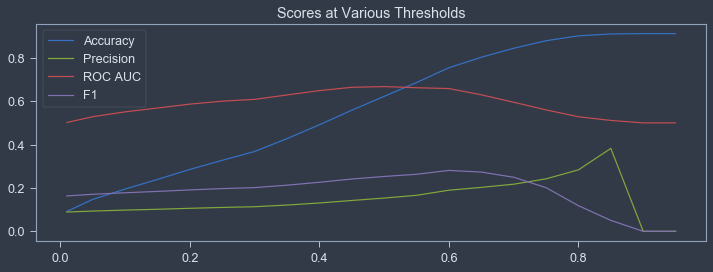

              precision    recall  f1-score   support

           0       0.95      0.78      0.85      4962
           1       0.19      0.54      0.28       482

    accuracy                           0.75      5444
   macro avg       0.57      0.66      0.57      5444
weighted avg       0.88      0.75      0.80      5444



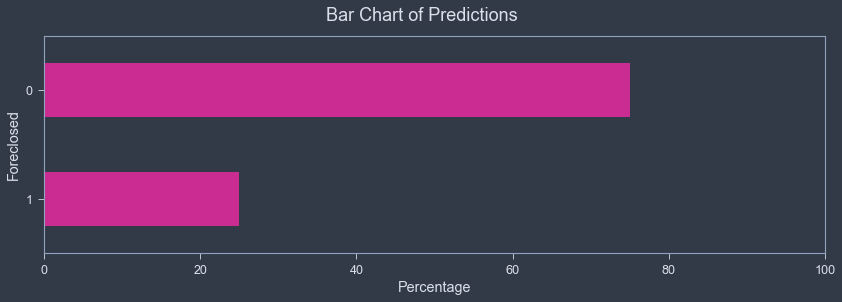

Frequency of Foreclosures
0    4113
1    1378
Name: 1, dtype: int64

Percentage of Foreclosures
0    75
1    25
Name: 1, dtype: int32

None
F1 Score 0.28

Confusion Matrix
[[3872 1116]
 [ 241  262]]

PNC Bank Model
 -  Pipeline(steps=[('sclr', StandardScaler()),
                ('rus',
                 RUSBoostClassifier(n_estimators=500, random_state=2023,
                                    sampling_strategy={0: 900, 1: 300}))])
Best Params
{'rus__learning_rate': 0.2}
Best Threshold


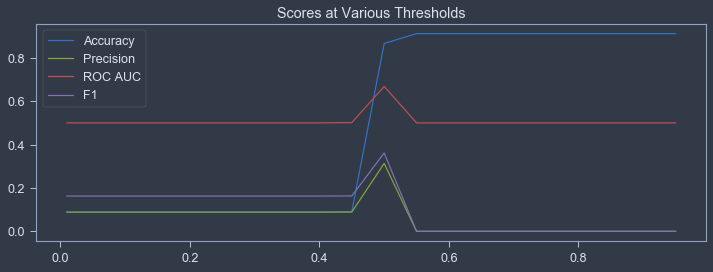

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      4962
           1       0.31      0.43      0.36       482

    accuracy                           0.87      5444
   macro avg       0.63      0.67      0.64      5444
weighted avg       0.89      0.87      0.88      5444



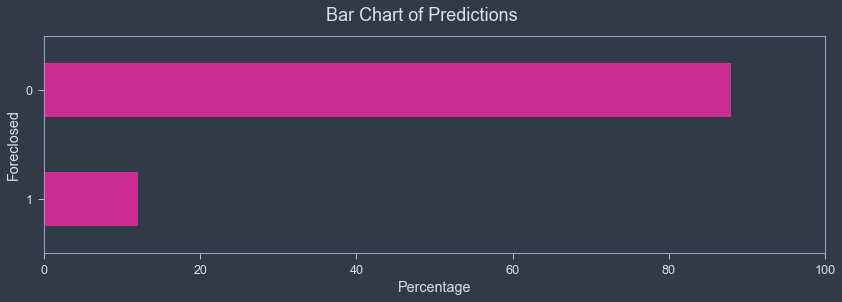

Frequency of Foreclosures
0    4823
1     668
Name: 1, dtype: int64

Percentage of Foreclosures
0    88
1    12
Name: 1, dtype: int32

None
F1 Score 0.35

Confusion Matrix
[[4522  466]
 [ 301  202]]

Flagstar Bank Model
 -  Pipeline(steps=[('sclr', StandardScaler()),
                ('rfc1',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_features='sqrt', n_jobs=-1,
                                                random_state=2020,
                                                sampling_strategy={0: 1500,
                                                                   1: 300}))])
Best Params
{'rfc1__min_samples_split': 2, 'rfc1__n_estimators': 50}
Best Threshold


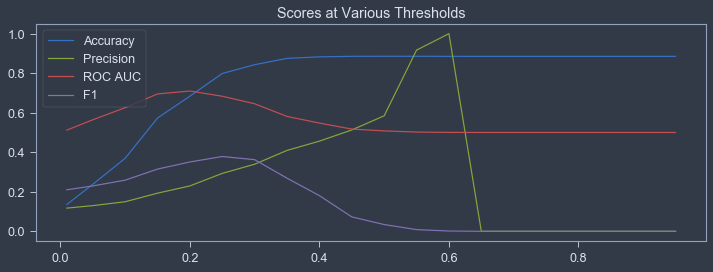

              precision    recall  f1-score   support

           0       0.93      0.83      0.88     19637
           1       0.29      0.53      0.38      2550

    accuracy                           0.80     22187
   macro avg       0.61      0.68      0.63     22187
weighted avg       0.86      0.80      0.82     22187



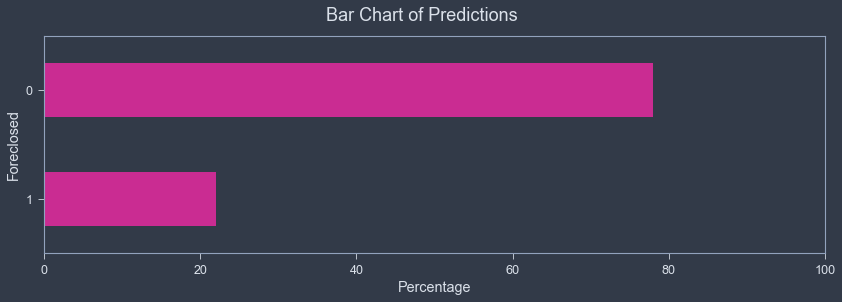

Frequency of Foreclosures
0    17146
1     4714
Name: 1, dtype: int64

Percentage of Foreclosures
0    78
1    22
Name: 1, dtype: int32

None
F1 Score 0.39

Confusion Matrix
[[16004  3294]
 [ 1142  1420]]

Flagstar Bank Model
 -  Pipeline(steps=[('sclr', StandardScaler()), ('pca', PCA()),
                ('rfc2',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_features=None, n_jobs=-1,
                                                random_state=2022,
                                                replacement=True))])
Best Params
{'pca__n_components': 15, 'rfc2__min_samples_split': 16, 'rfc2__n_estimators': 500}
Best Threshold


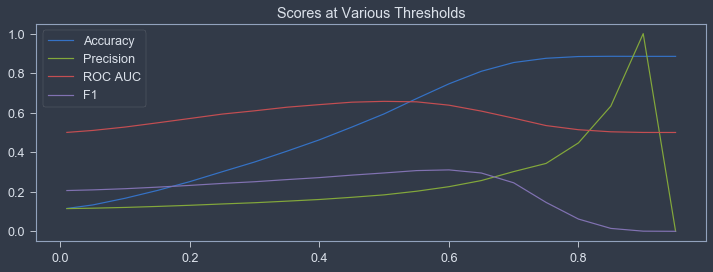

              precision    recall  f1-score   support

           0       0.92      0.78      0.84     19637
           1       0.23      0.50      0.31      2550

    accuracy                           0.75     22187
   macro avg       0.57      0.64      0.58     22187
weighted avg       0.84      0.75      0.78     22187



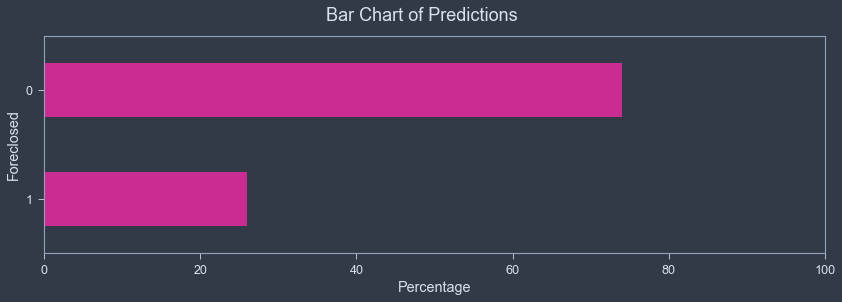

Frequency of Foreclosures
0    16248
1     5612
Name: 1, dtype: int64

Percentage of Foreclosures
0    74
1    26
Name: 1, dtype: int32

None
F1 Score 0.32

Confusion Matrix
[[14980  4318]
 [ 1268  1294]]

Flagstar Bank Model
 -  Pipeline(steps=[('sclr', StandardScaler()),
                ('rus',
                 RUSBoostClassifier(n_estimators=500, random_state=2023,
                                    sampling_strategy={0: 900, 1: 300}))])
Best Params
{'rus__learning_rate': 0.15}
Best Threshold


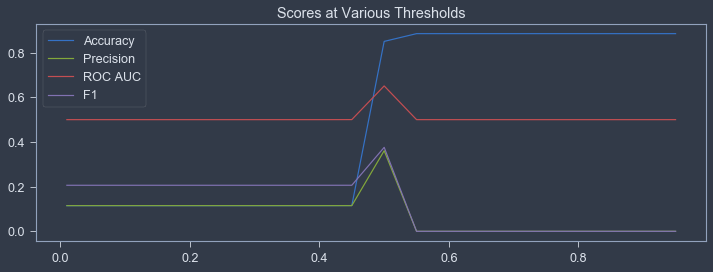

              precision    recall  f1-score   support

           0       0.92      0.91      0.91     19637
           1       0.36      0.39      0.38      2550

    accuracy                           0.85     22187
   macro avg       0.64      0.65      0.65     22187
weighted avg       0.86      0.85      0.85     22187



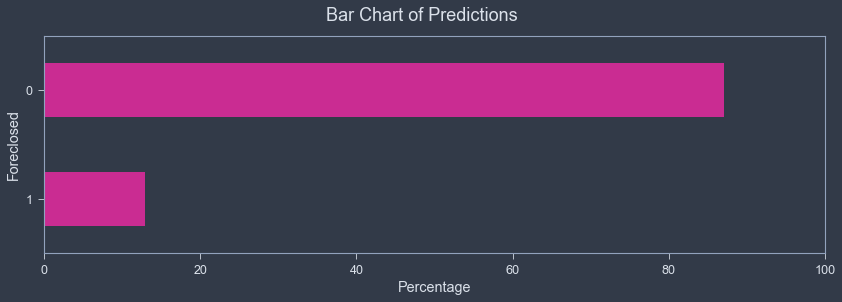

Frequency of Foreclosures
0    18960
1     2900
Name: 1, dtype: int64

Percentage of Foreclosures
0    87
1    13
Name: 1, dtype: int32

None
F1 Score 0.39

Confusion Matrix
[[17474  1824]
 [ 1486  1076]]

All Banks Model
 -  Pipeline(steps=[('sclr', StandardScaler()),
                ('rfc1',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_features='sqrt', n_jobs=-1,
                                                random_state=2020,
                                                sampling_strategy={0: 1500,
                                                                   1: 300}))])
Best Params
{'rfc1__min_samples_split': 4, 'rfc1__n_estimators': 50}
Best Threshold


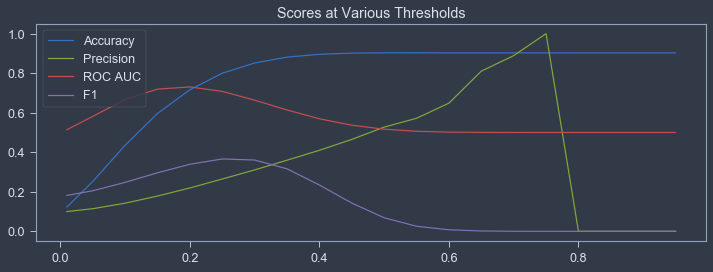

              precision    recall  f1-score   support

           0       0.95      0.82      0.88    509214
           1       0.26      0.59      0.37     54944

    accuracy                           0.80    564158
   macro avg       0.61      0.71      0.62    564158
weighted avg       0.88      0.80      0.83    564158



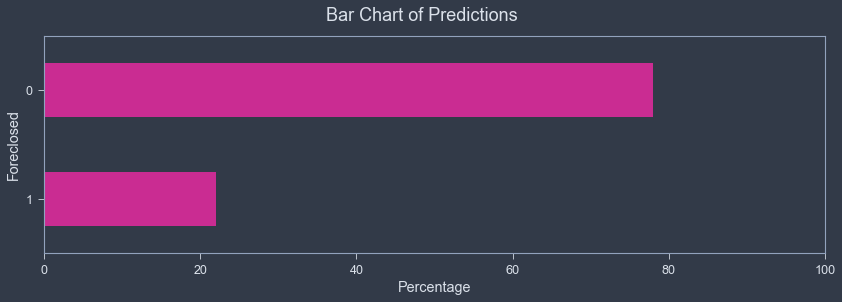

Frequency of Foreclosures
0    440425
1    123734
Name: 1, dtype: int64

Percentage of Foreclosures
0    78
1    22
Name: 1, dtype: int32

None
F1 Score 0.37

Confusion Matrix
[[418112  91102]
 [ 22313  32632]]

All Banks Model
 -  Pipeline(steps=[('sclr', StandardScaler()), ('pca', PCA()),
                ('rfc2',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_features=None, n_jobs=-1,
                                                random_state=2022,
                                                replacement=True))])
Best Params
{'pca__n_components': 15, 'rfc2__min_samples_split': 16, 'rfc2__n_estimators': 500}
Best Threshold


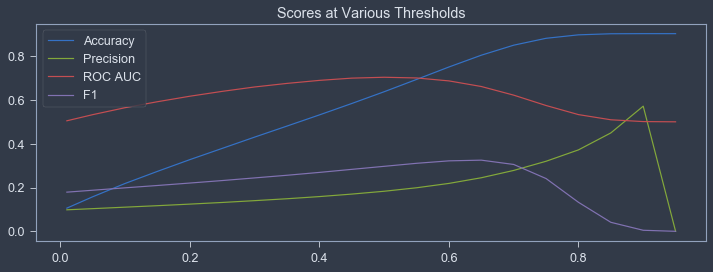

              precision    recall  f1-score   support

           0       0.94      0.84      0.89    509214
           1       0.24      0.48      0.32     54944

    accuracy                           0.80    564158
   macro avg       0.59      0.66      0.61    564158
weighted avg       0.87      0.80      0.83    564158



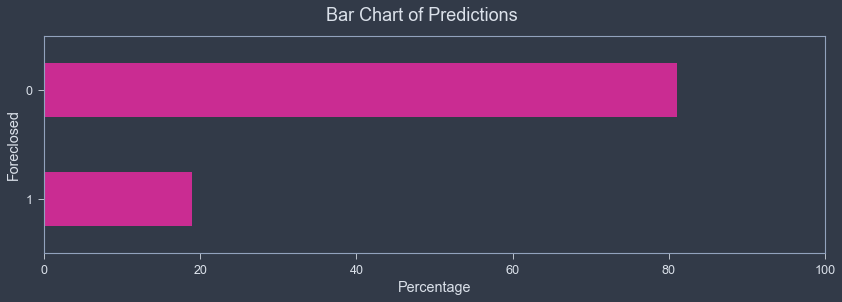

Frequency of Foreclosures
0    455470
1    108689
Name: 1, dtype: int64

Percentage of Foreclosures
0    81
1    19
Name: 1, dtype: int32

None
F1 Score 0.32

Confusion Matrix
[[427019  82195]
 [ 28451  26494]]

All Banks Model
 -  Pipeline(steps=[('sclr', StandardScaler()),
                ('rus',
                 RUSBoostClassifier(n_estimators=500, random_state=2023,
                                    sampling_strategy={0: 900, 1: 300}))])
Best Params
{'rus__learning_rate': 0.1}
Best Threshold


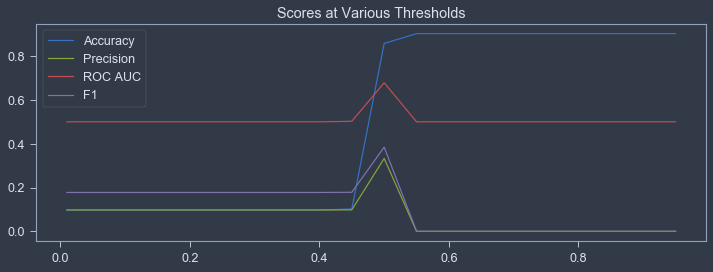

              precision    recall  f1-score   support

           0       0.94      0.90      0.92    509214
           1       0.33      0.46      0.38     54944

    accuracy                           0.86    564158
   macro avg       0.64      0.68      0.65    564158
weighted avg       0.88      0.86      0.87    564158



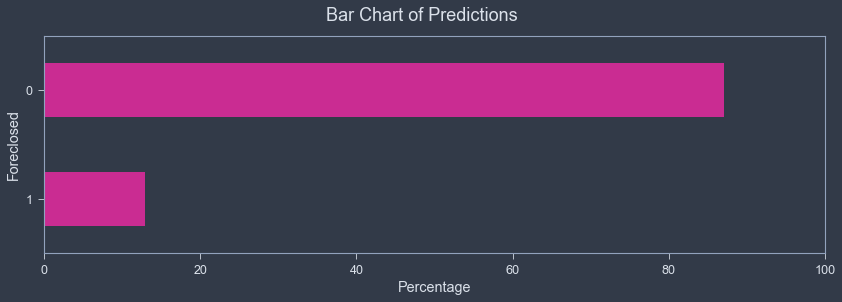

Frequency of Foreclosures
0    488922
1     75237
Name: 1, dtype: int64

Percentage of Foreclosures
0    87
1    13
Name: 1, dtype: int32

None
F1 Score 0.38

Confusion Matrix
[[459034  50180]
 [ 29888  25057]]



In [6]:
# Run bottom layer models (Ind banks/all banks)

## Bank and Classifier Lists
banks_plus = banks + ['All Banks']
clfs = [rfc1, rfc2, rus] 
clfs_str = ['RFC', 'RFC PCA', 'RUS Boost'] 

## Save full data
Banks_y['All Banks'] = y_train
Banks_X['All Banks'] = X_train
Banks_y_val['All Banks'] = y_val
Banks_X_val['All Banks'] = X_val
Banks_y_test['All Banks'] = y_test
Banks_X_test['All Banks'] = X_test

## Run Classifier Function
vote_models, \
vote_thresholds, \
vote_proba, \
vote_pred = clf_pred_func(bnk_list = banks_plus, clfs = clfs, clfs_str = clfs_str, \
                          Banks_y = Banks_y, Banks_X = Banks_X, \
                          Banks_y_val = Banks_y_val, Banks_X_val = Banks_X_val, \
                          Banks_y_test = Banks_y_test, Banks_X_test = Banks_X_test)

In [7]:
# Vote classifier
## Create voting dataframes
votes = votes_clf_func(vote_pred = vote_pred, bnk_list = banks_plus, 
                       clfs_str = clfs_str, X = Bnk_test)

***

# Middle Layer

In [8]:
combined_votes = pd.Series()
combined_actuals = pd.Series()

# Middle layer
for bank_str in banks:
    print(bank_str)
    all_bnks_pred = ( votes['All Banks'].iloc[:,:len(clfs_str)].sum(axis=1) / 
                      len(clfs_str) ) \
                      .map(lambda x: 1 if x == 1.0 else 0)    
    votes[bank_str].loc[:,'All Banks'] = all_bnks_pred.loc[Bnk_test == bank_str].reset_index().iloc[:,1]
    total_vote = votes[bank_str].loc[:,'All Banks']
    votes[bank_str].loc[:,'All Banks 2'] = total_vote
    print('Predicted Foreclosures', np.mean(total_vote).round(2))
    print('Actual Foreclosures', np.mean(Banks_y_test[bank_str]).round(2))
    print('F1 Score after Voting', f1_score(Banks_y_test[bank_str], total_vote).round(2))
    print('Recall after Voting', recall_score(Banks_y_test[bank_str], total_vote).round(2))        
    print('Precision after Voting', precision_score(Banks_y_test[bank_str], total_vote).round(2))    
    print('')
    
    # Combine banks
    combined_votes = pd.concat([combined_votes, total_vote], axis=0)
    combined_actuals = pd.concat([combined_actuals, Banks_y_test[bank_str]], axis=0)
    
print('Combined Predictions')
print('Predicted Foreclosures', np.mean(combined_votes).round(2))
print('Actual Foreclosures', np.mean(combined_actuals).round(2))
print('F1 Score after Voting', f1_score(combined_actuals, combined_votes).round(2))
print('Recall after Voting', recall_score(combined_actuals, combined_votes).round(2))        
print('Precision after Voting', precision_score(combined_actuals, combined_votes).round(2))    

Bank of America
Predicted Foreclosures 0.11
Actual Foreclosures 0.12
F1 Score after Voting 0.4
Recall after Voting 0.39
Precision after Voting 0.41

Wells Fargo Bank
Predicted Foreclosures 0.06
Actual Foreclosures 0.08
F1 Score after Voting 0.28
Recall after Voting 0.25
Precision after Voting 0.31

CitiMortgage
Predicted Foreclosures 0.05
Actual Foreclosures 0.08
F1 Score after Voting 0.27
Recall after Voting 0.23
Precision after Voting 0.33

JPMorgan Chase
Predicted Foreclosures 0.05
Actual Foreclosures 0.08
F1 Score after Voting 0.3
Recall after Voting 0.26
Precision after Voting 0.36

GMAC Mortgage
Predicted Foreclosures 0.06
Actual Foreclosures 0.1
F1 Score after Voting 0.25
Recall after Voting 0.2
Precision after Voting 0.32

SunTrust Mortgage
Predicted Foreclosures 0.06
Actual Foreclosures 0.1
F1 Score after Voting 0.29
Recall after Voting 0.22
Precision after Voting 0.4

AmTrust Bank
Predicted Foreclosures 0.05
Actual Foreclosures 0.1
F1 Score after Voting 0.22
Recall after Voti

***

# Top Layer

In [16]:
combined_votes = pd.Series()
combined_actuals = pd.Series()

# Final vote
for bank_str in banks:
    print(bank_str)
    votes[bank_str].loc[:,'Majority'] = ( votes[bank_str].iloc[:,:(len(clfs_str)+1)].sum(axis=1) / 
                                        ( len(clfs_str)+1 ) ) \
                                        .map(lambda x: 1 if x > 0.67 else 0)
    total_vote = votes[bank_str].loc[:,'Majority']
    print('Predicted Foreclosures', np.mean(total_vote).round(2))
    print('Actual Foreclosures', np.mean(Banks_y_test[bank_str]).round(2))
    print('F1 Score after Voting', f1_score(Banks_y_test[bank_str], total_vote).round(2))
    print('Recall after Voting', recall_score(Banks_y_test[bank_str], total_vote).round(2))        
    print('Precision after Voting', precision_score(Banks_y_test[bank_str], total_vote).round(2))    
    print('')
    
    # Combine banks
    combined_votes = pd.concat([combined_votes, total_vote], axis=0)
    combined_actuals = pd.concat([combined_actuals, Banks_y_test[bank_str]], axis=0)
    
print('Combined Predictions')
print('Predicted Foreclosures', np.mean(combined_votes).round(2))
print('Actual Foreclosures', np.mean(combined_actuals).round(2))
print('F1 Score after Voting', f1_score(combined_actuals, combined_votes).round(2))
print('Recall after Voting', recall_score(combined_actuals, combined_votes).round(2))        
print('Precision after Voting', precision_score(combined_actuals, combined_votes).round(2))   
print('Accuracy after Voting', accuracy_score(combined_actuals, combined_votes).round(2)) 
print('')
print('Confusion Matrix')
print(confusion_matrix(combined_actuals, combined_votes))

Bank of America
Predicted Foreclosures 0.13
Actual Foreclosures 0.12
F1 Score after Voting 0.43
Recall after Voting 0.45
Precision after Voting 0.4

Wells Fargo Bank
Predicted Foreclosures 0.08
Actual Foreclosures 0.08
F1 Score after Voting 0.32
Recall after Voting 0.32
Precision after Voting 0.31

CitiMortgage
Predicted Foreclosures 0.08
Actual Foreclosures 0.08
F1 Score after Voting 0.33
Recall after Voting 0.34
Precision after Voting 0.33

JPMorgan Chase
Predicted Foreclosures 0.08
Actual Foreclosures 0.08
F1 Score after Voting 0.36
Recall after Voting 0.36
Precision after Voting 0.36

GMAC Mortgage
Predicted Foreclosures 0.09
Actual Foreclosures 0.1
F1 Score after Voting 0.33
Recall after Voting 0.32
Precision after Voting 0.34

SunTrust Mortgage
Predicted Foreclosures 0.08
Actual Foreclosures 0.1
F1 Score after Voting 0.36
Recall after Voting 0.32
Precision after Voting 0.41

AmTrust Bank
Predicted Foreclosures 0.09
Actual Foreclosures 0.1
F1 Score after Voting 0.31
Recall after V

***

# Save Objects

In [10]:
# Models
file_to_store = open("..\Data\Pickle\models.pkl", "wb")
pickle.dump(vote_models, file_to_store)
file_to_store.close()

# Thresholds
file_to_store = open("..\Data\Pickle\model_thresholds.pkl", "wb")
pickle.dump(vote_thresholds, file_to_store)
file_to_store.close()

# Predictions
file_to_store = open("..\Data\Pickle\predictions.pkl", "wb")
pickle.dump(vote_pred, file_to_store)
file_to_store.close()

# Final Votes
file_to_store = open("..\Data\Pickle\df_votes.pkl", "wb")
pickle.dump(votes, file_to_store)
file_to_store.close()

***